In [77]:
import numpy as np
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [42]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

scaler = StandardScaler() #표준화 전처리 클래스 객체 생성
scaler.fit(x_train) #훈련 세트에 대하여 전처리 규칙 익힘
x_train_scaled = scaler.transform(x_train) #훈련세트 표준화 적용
x_val_scaled = scaler.transform(x_val) #검증세트 표준화 적용

In [69]:
#다중 분류 신경망 구현
class MultiClassNetwork :

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0) :
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x) :
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.sigmoid(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2

  def backprop(self, x, err) :
    m = len(x)
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z1) :
    a = 1 / (1 + np.exp(-z1))
    return a

  def softmax(self, z) :
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1,1)

  def init_weights(self, n_features, n_classes) :
    self.w1 = np.random.normal(0,1, (n_features, self.units) )
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0,1, (self.units, n_classes) )
    self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None) :
    np.random.seed(42)
    self.init_weights(x.shape[1], y.shape[1])
    for i in range(epochs) :
      loss = 0
      print('.', end='') #편의상 훈련 진행상황 알 수 있게끔 에포크마다 '.' 출력
      for x_batch, y_batch in self.gen_batch(x, y) :
        a = self.training(x_batch, y_batch)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += np.sum(-y_batch*np.log(a))
      self.losses.append( (loss + self.reg_loss()) / len(x) )
      self.update_val_loss(x_val, y_val)

  def gen_batch(self, x, y) :
    length = len(x)
    bins = length // self.batch_size
    if length % self.batch_size :
      bins += 1
      indexes = np.random.permutation(np.arange(len(x)))
      x = x[indexes]
      y = y[indexes]
      for i in range(bins) :
        start = self.batch_size * i
        end = self.batch_size * (i + 1)
        yield x[start:end], y[start:end]

  def training(self, x, y) :
    m = len(x)
    z = self.forpass(x)
    a = self.softmax(z)
    err = -(y-a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def predict(self, x) :
    z = self.forpass(x)
    return np.argmax(z, axis=1)

  def score(self, x, y) :
    return np.mean(self.predict(x) == np.argmax(y, axis=1))

  def reg_loss(self) :
    return self.l1 * ( np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2)) ) + \
          self.l2 / 2 * (  np.sum(self.w1**2) + np.sum(self.w2**2) )

  def update_val_loss(self, x_val, y_val) :
    z = self.forpass(x_val)
    a = self.softmax(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-y_val * np.log(a))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [44]:
import tensorflow as tf

In [45]:
tf.__version__

'2.19.0'

In [46]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [47]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


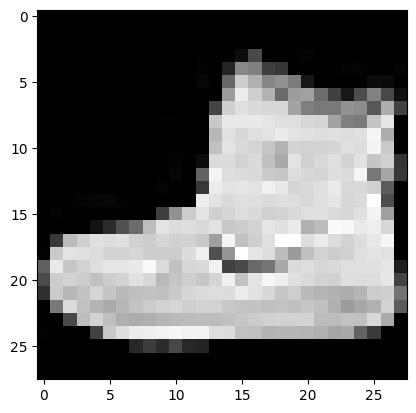

In [48]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0],cmap='gray')
plt.show()

In [49]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [50]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

In [51]:
print(class_names[y_train_all[0]])

앵클부츠


In [52]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [53]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [54]:
print(np.bincount(y_train))
print(np.bincount(y_val))

[4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
[1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


In [55]:
#입력데이터 정규화: 각 요소마다 0~255사이의 값 가지므로 255로 나눠 모든 값을 0~1사이로 맞춤
x_train = x_train / 255
x_val = x_val / 255

In [56]:
#내가 만든 코드는 1차원 배열 취급->2차원 이미지의 픽셀을 1줄로 나란히 붙이는 작업(1차원 배열로 전환)
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [57]:
tf.keras.utils.to_categorical( [0,1,3] )

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [58]:
#타깃 데이터 원-핫 인코딩하기
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [59]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [60]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [70]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

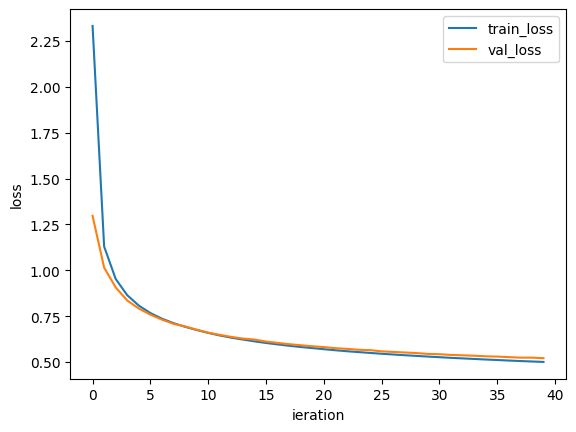

In [71]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('ieration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [72]:
fc.score(x_val, y_val_encoded)

np.float64(0.8150833333333334)

### **텐서플로와 케라스 사용하여 신경망 만들기**

In [89]:
#Sequential 클래스 : 인공신경망 모델 만듦
#Dense 클래스 : 완전 연결층 만듦
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
#완전연결신경망 만드는 방법
#1) Sequential클래스의 객체를 생성할 때 층을 추가하는 방법
# (ex) model = Sequential( [Dense(...), ...] )

In [ ]:
#2) Sequential클래스의 객체를 생성한 후 add()매서드로 층을 추가하는 방법
# (ex) dense = Dense(...)
#      model.add(dense)
# (ex) model = Sequential()
#      model.add(Dense(...))

In [90]:
model = Sequential() #모델 생성
model.add( Dense(100, activation='sigmoid', input_shape=(784,)) ) #은닉층 추가 (input_shape로 샘플개수 생략한 나머지 차원을 지정해주어야 함)
model.add( Dense(10, activation='softmax')) #출력층 추가
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) #최적화 알고리즘, 손실함수, 훈련과정에서 '정확도' 기록 추가

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [103]:
print(x_train.shape)

(48000, 784)


In [91]:
history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))
#validation_data로 검증세트를 튜플로 묶어 계산 -> 훈련하는 동안 검증세트에 대한 손실과 정확도도 계산

Epoch 1/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5360 - loss: 1.7265 - val_accuracy: 0.7386 - val_loss: 0.9522
Epoch 2/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7405 - loss: 0.8841 - val_accuracy: 0.7612 - val_loss: 0.7439
Epoch 3/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7603 - loss: 0.7306 - val_accuracy: 0.7802 - val_loss: 0.6588
Epoch 4/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7784 - loss: 0.6584 - val_accuracy: 0.7955 - val_loss: 0.6112
Epoch 5/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7915 - loss: 0.6106 - val_accuracy: 0.8040 - val_loss: 0.5752
Epoch 6/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8023 - loss: 0.5771 - val_accuracy: 0.8100 - val_loss: 0.5487
Epoch 7/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8121 - loss: 0.5505 - val_accuracy: 0.8181 - val_loss: 0.5279
Epoch 8/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8163 - loss: 0.5299 -

In [97]:
print(history.history.keys())
print(history.history['accuracy'])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
[0.6555416584014893, 0.7479375004768372, 0.7681249976158142, 0.7821875214576721, 0.7960000038146973, 0.8046875, 0.81270831823349, 0.816979169845581, 0.8218125104904175, 0.8260416388511658, 0.8285624980926514, 0.831125020980835, 0.8331458568572998, 0.8357499837875366, 0.8383125066757202, 0.8400833606719971, 0.8417708277702332, 0.8429791927337646, 0.8442708253860474, 0.8456249833106995, 0.8461458086967468, 0.8485000133514404, 0.8493750095367432, 0.8498958349227905, 0.8512499928474426, 0.8512083292007446, 0.8529791831970215, 0.8528333306312561, 0.854604184627533, 0.854520857334137, 0.856374979019165, 0.8566041588783264, 0.8572708368301392, 0.8580416440963745, 0.8582500219345093, 0.8593958616256714, 0.8600416779518127, 0.8606874942779541, 0.8615416884422302, 0.8615833520889282]


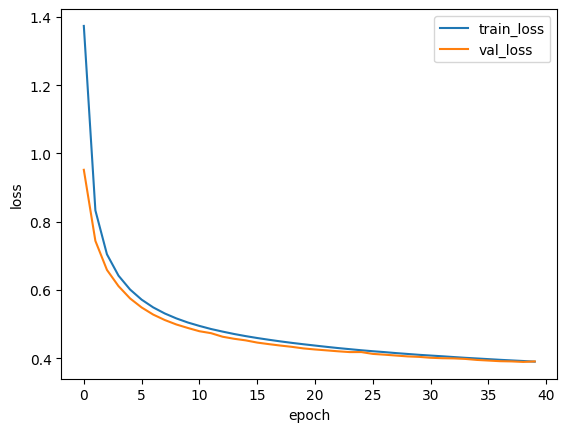

In [98]:
#손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

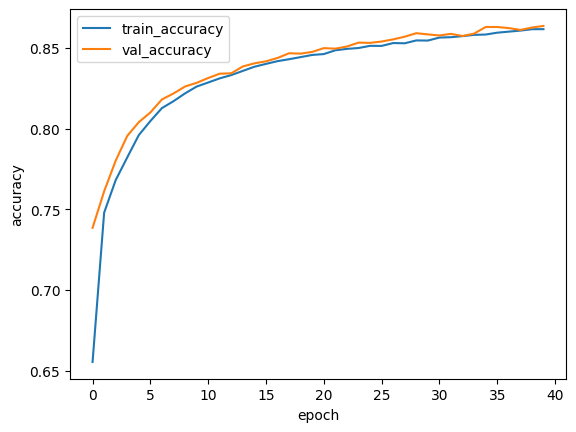

In [102]:
#정확도 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [104]:
#검증세트 정확도 반환하기
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.8635833263397217
